# Share Weights Dense AutoEncoder
Keywords :
1. Keras **functional api**
2. **Customized Keras Layer** that has a transpose argument when call()
2. Scatter plot of embeddings
3. Image generation from embedding

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Reshape, Layer
from tensorflow.keras import Model
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pylab

## A. Data Loading and Plotting

In [2]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train),(x_test, y_test) = fmnist.load_data()
train_num, h, w = x_train.shape
x_train, x_test = x_train[...,tf.newaxis]/255.0 - 0.5, x_test[...,tf.newaxis]/255.0 - 0.5

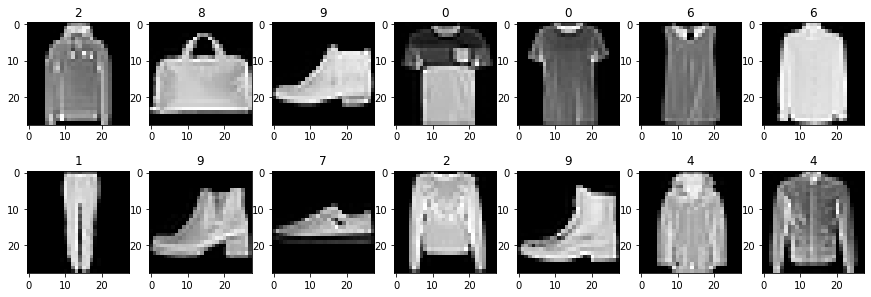

In [3]:
plt.figure(figsize=(15,5))
for i in np.arange(2*7):
    random_idx = np.random.randint(0,x_train.shape[0])
    plt.subplot(2,7,i+1)
    plt.imshow(x_train[random_idx].reshape(28,28),cmap='gray')
    plt.title(y_train[random_idx])

### Use `tf.data` to batch and shuffle the dataset:

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)

## B. Model Construction with Keras Functional API

In [5]:
embedding_dim = 2
n_classes = len(np.unique(y_train))
fc_input_dim = h*w

In [6]:
# see https://github.com/tensorflow/tensorflow/blob/v2.1.0/tensorflow/python/keras/layers/core.py
# for the Dense class definition
# ref https://stackoverflow.com/questions/57827274/keras-autoencoder-tying-weights-from-encoder-to-decoder-not-working
class TransposableDense(Dense):
    def __init__(self, units, **kwargs):
        super().__init__(units, **kwargs)

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        print(input_dim)
        self.t_output_dim = input_dim

        self.kernel = self.add_weight(shape=(int(input_dim), self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
            self.bias_t = self.add_weight(shape=(input_dim,),
                                          initializer=self.bias_initializer,
                                          name='bias_t',
                                          regularizer=self.bias_regularizer,
                                          constraint=self.bias_constraint)
        else:
            self.bias = None
            self.bias_t = None
        self.built = True

    def call(self, inputs, transpose=False):
        bs, input_dim = inputs.get_shape()

        kernel = self.kernel
        bias = self.bias
        if transpose:
            assert input_dim == self.units
            kernel = tf.keras.backend.transpose(kernel)
            bias = self.bias_t

        output = tf.keras.backend.dot(inputs, kernel)
        if self.use_bias:
            output = tf.keras.backend.bias_add(output, bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output
    
    def compute_output_shape(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        input_shape = input_shape.with_rank_at_least(2)
        if tensor_shape.dimension_value(input_shape[-1]) is None:
            raise ValueError(
                'The innermost dimension of input_shape must be defined, but saw: %s'
                % input_shape)
        return input_shape[:-1].concatenate(self.units)
    
dense1 = TransposableDense(128, activation='relu', use_bias=True)
dense2 = TransposableDense(32, activation='relu', use_bias=True)
embLayer = TransposableDense(embedding_dim, activation=None)
reshapeLayer = Reshape(target_shape=(h,w,1))

in_imgs = tf.keras.layers.Input((h,w,1))
flatten = Flatten()(in_imgs)
d1 = dense1(flatten)
d2 = dense2(d1)
embs = embLayer(d2)
encodeModel = tf.keras.Model(in_imgs,embs)

in_embs = tf.keras.layers.Input((embedding_dim,))
emb_transpose = embLayer(in_embs, transpose=True)
d2_transpose = dense2(emb_transpose, transpose=True)
d1_transpose = dense1(d2_transpose, transpose=True)
rec_imgs = reshapeLayer(d1_transpose)
decodeModel = tf.keras.Model(in_embs,rec_imgs)

784
128
32


In [7]:
encodeModel.summary()
decodeModel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
transposable_dense (Transpos multiple                  101264    
_________________________________________________________________
transposable_dense_1 (Transp multiple                  4256      
_________________________________________________________________
transposable_dense_2 (Transp multiple                  98        
Total params: 105,618
Trainable params: 105,618
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Sh

## C. Train

In [8]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [9]:
@tf.function
def train_step(images):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        embbedings = encodeModel(images, training=True)
        img_recs = decodeModel(embbedings, training=True)
        loss = loss_object(images,img_recs)
    trainable_variables = encodeModel.trainable_variables + decodeModel.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    train_loss(loss)

In [10]:
@tf.function
def find_emb_step(images):
    embs = encodeModel(images, training=False)
    return embs
@tf.function
def find_rec_step(embs):
    recs = decodeModel(embs, training=False)
    return recs

In [11]:
EPOCHS = 15
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    for images, labels in train_ds:
        train_step(images)
    template = 'Epoch {}, Loss: {}'
    print(template.format(epoch+1, train_loss.result()))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.15561999380588531
Epoch 2, Loss: 0.15432868897914886
Epoch 3, Loss: 0.15400779247283936
Epoch 4, Loss: 0.15382711589336395
Epoch 5, Loss: 0.15369224548339844
Epoch 6, Loss: 0.1535750925540924
Epoch 7, Loss: 0.15346397459506989
Epoch 8, Loss: 0.15338876843452454
Epoch 9, Loss: 0.15332959592342377
Epoch 10, Loss: 0.15328139066696167
Epoch 11, Loss: 0.15324392914772034
Epoch 12, Loss: 0.15320201218128204
Epoch 13, Loss: 0.15316885709762573
Epoch 14, Loss: 0.15314756333827972
Epoch 15, Loss

In [12]:
print('encodeModel Layers are:')
_ = [print(l.name) for l in encodeModel.layers]
print('\nencodeModel Variables are:')
_ = [print(var.name, var.shape, var.device) for var in encodeModel.variables]

print('\ndencodeModel Layers are:')
_ = [print(l.name) for l in decodeModel.layers]
print('\ndecodeModel Variables are:')
_ = [print(var.name, var.shape, var.device) for var in decodeModel.variables]

encodeModel Layers are:
input_1
flatten
transposable_dense
transposable_dense_1
transposable_dense_2

encodeModel Variables are:
transposable_dense/kernel:0 (784, 128) /job:localhost/replica:0/task:0/device:GPU:0
transposable_dense/bias:0 (128,) /job:localhost/replica:0/task:0/device:GPU:0
transposable_dense/bias_t:0 (784,) /job:localhost/replica:0/task:0/device:GPU:0
transposable_dense_1/kernel:0 (128, 32) /job:localhost/replica:0/task:0/device:GPU:0
transposable_dense_1/bias:0 (32,) /job:localhost/replica:0/task:0/device:GPU:0
transposable_dense_1/bias_t:0 (128,) /job:localhost/replica:0/task:0/device:GPU:0
transposable_dense_2/kernel:0 (32, 2) /job:localhost/replica:0/task:0/device:GPU:0
transposable_dense_2/bias:0 (2,) /job:localhost/replica:0/task:0/device:GPU:0
transposable_dense_2/bias_t:0 (32,) /job:localhost/replica:0/task:0/device:GPU:0

dencodeModel Layers are:
input_2
transposable_dense_2
transposable_dense_1
transposable_dense
reshape

decodeModel Variables are:
transposab

## D. Plot Embeddings

In [13]:
# dot colors
cmap=list()
for i in np.arange(n_classes):
    cmap.append(np.random.rand(1,3))
print(cmap[0])
permute_idx = np.random.permutation(n_classes)
cmap = [cmap[i] for i in permute_idx]

[[0.24980334 0.70887568 0.87805795]]


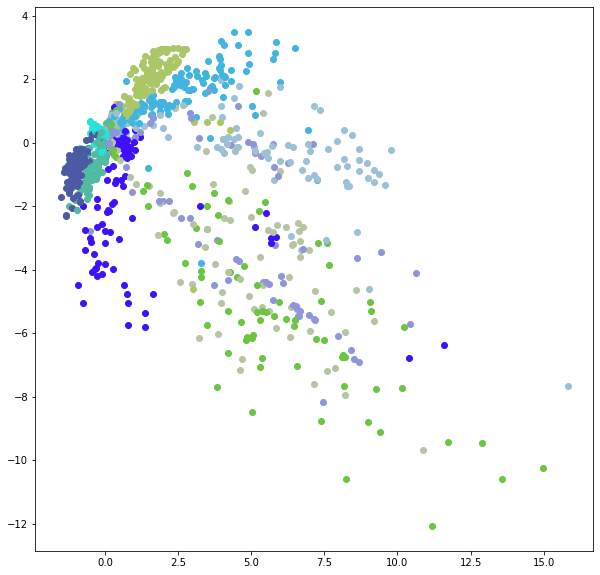

In [14]:
scatter_x = x_train[::50]
scatter_y = y_train[::50]
embeddings = encodeModel(scatter_x)
embeddings = embeddings.numpy()
img_num = len(scatter_x)
pylab.figure(figsize=(10,10))
for i in np.arange(0,img_num):
    x, y = (embeddings[i,0],embeddings[i,1])
    pylab.scatter(x,y,c=cmap[scatter_y[i]])
    #pylab.scatter(x,y,c=[[1,1,1]])
    #pylab.annotate(str(labels[i][0]), xy=(x,y), xytext=(0, 0), textcoords='offset points',
                   #ha='right', va='bottom')
pylab.show()

## E. Do Image Generation by Decoder

In [15]:
codes = list()
for xdim in np.arange(-2,2,0.2):
    for ydim in np.arange(-2,2,0.2):
        codes.append([xdim,ydim])
codes = tf.constant(codes,dtype=tf.float64)
print(codes.shape)
sampled_img = decodeModel(codes)

(400, 2)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



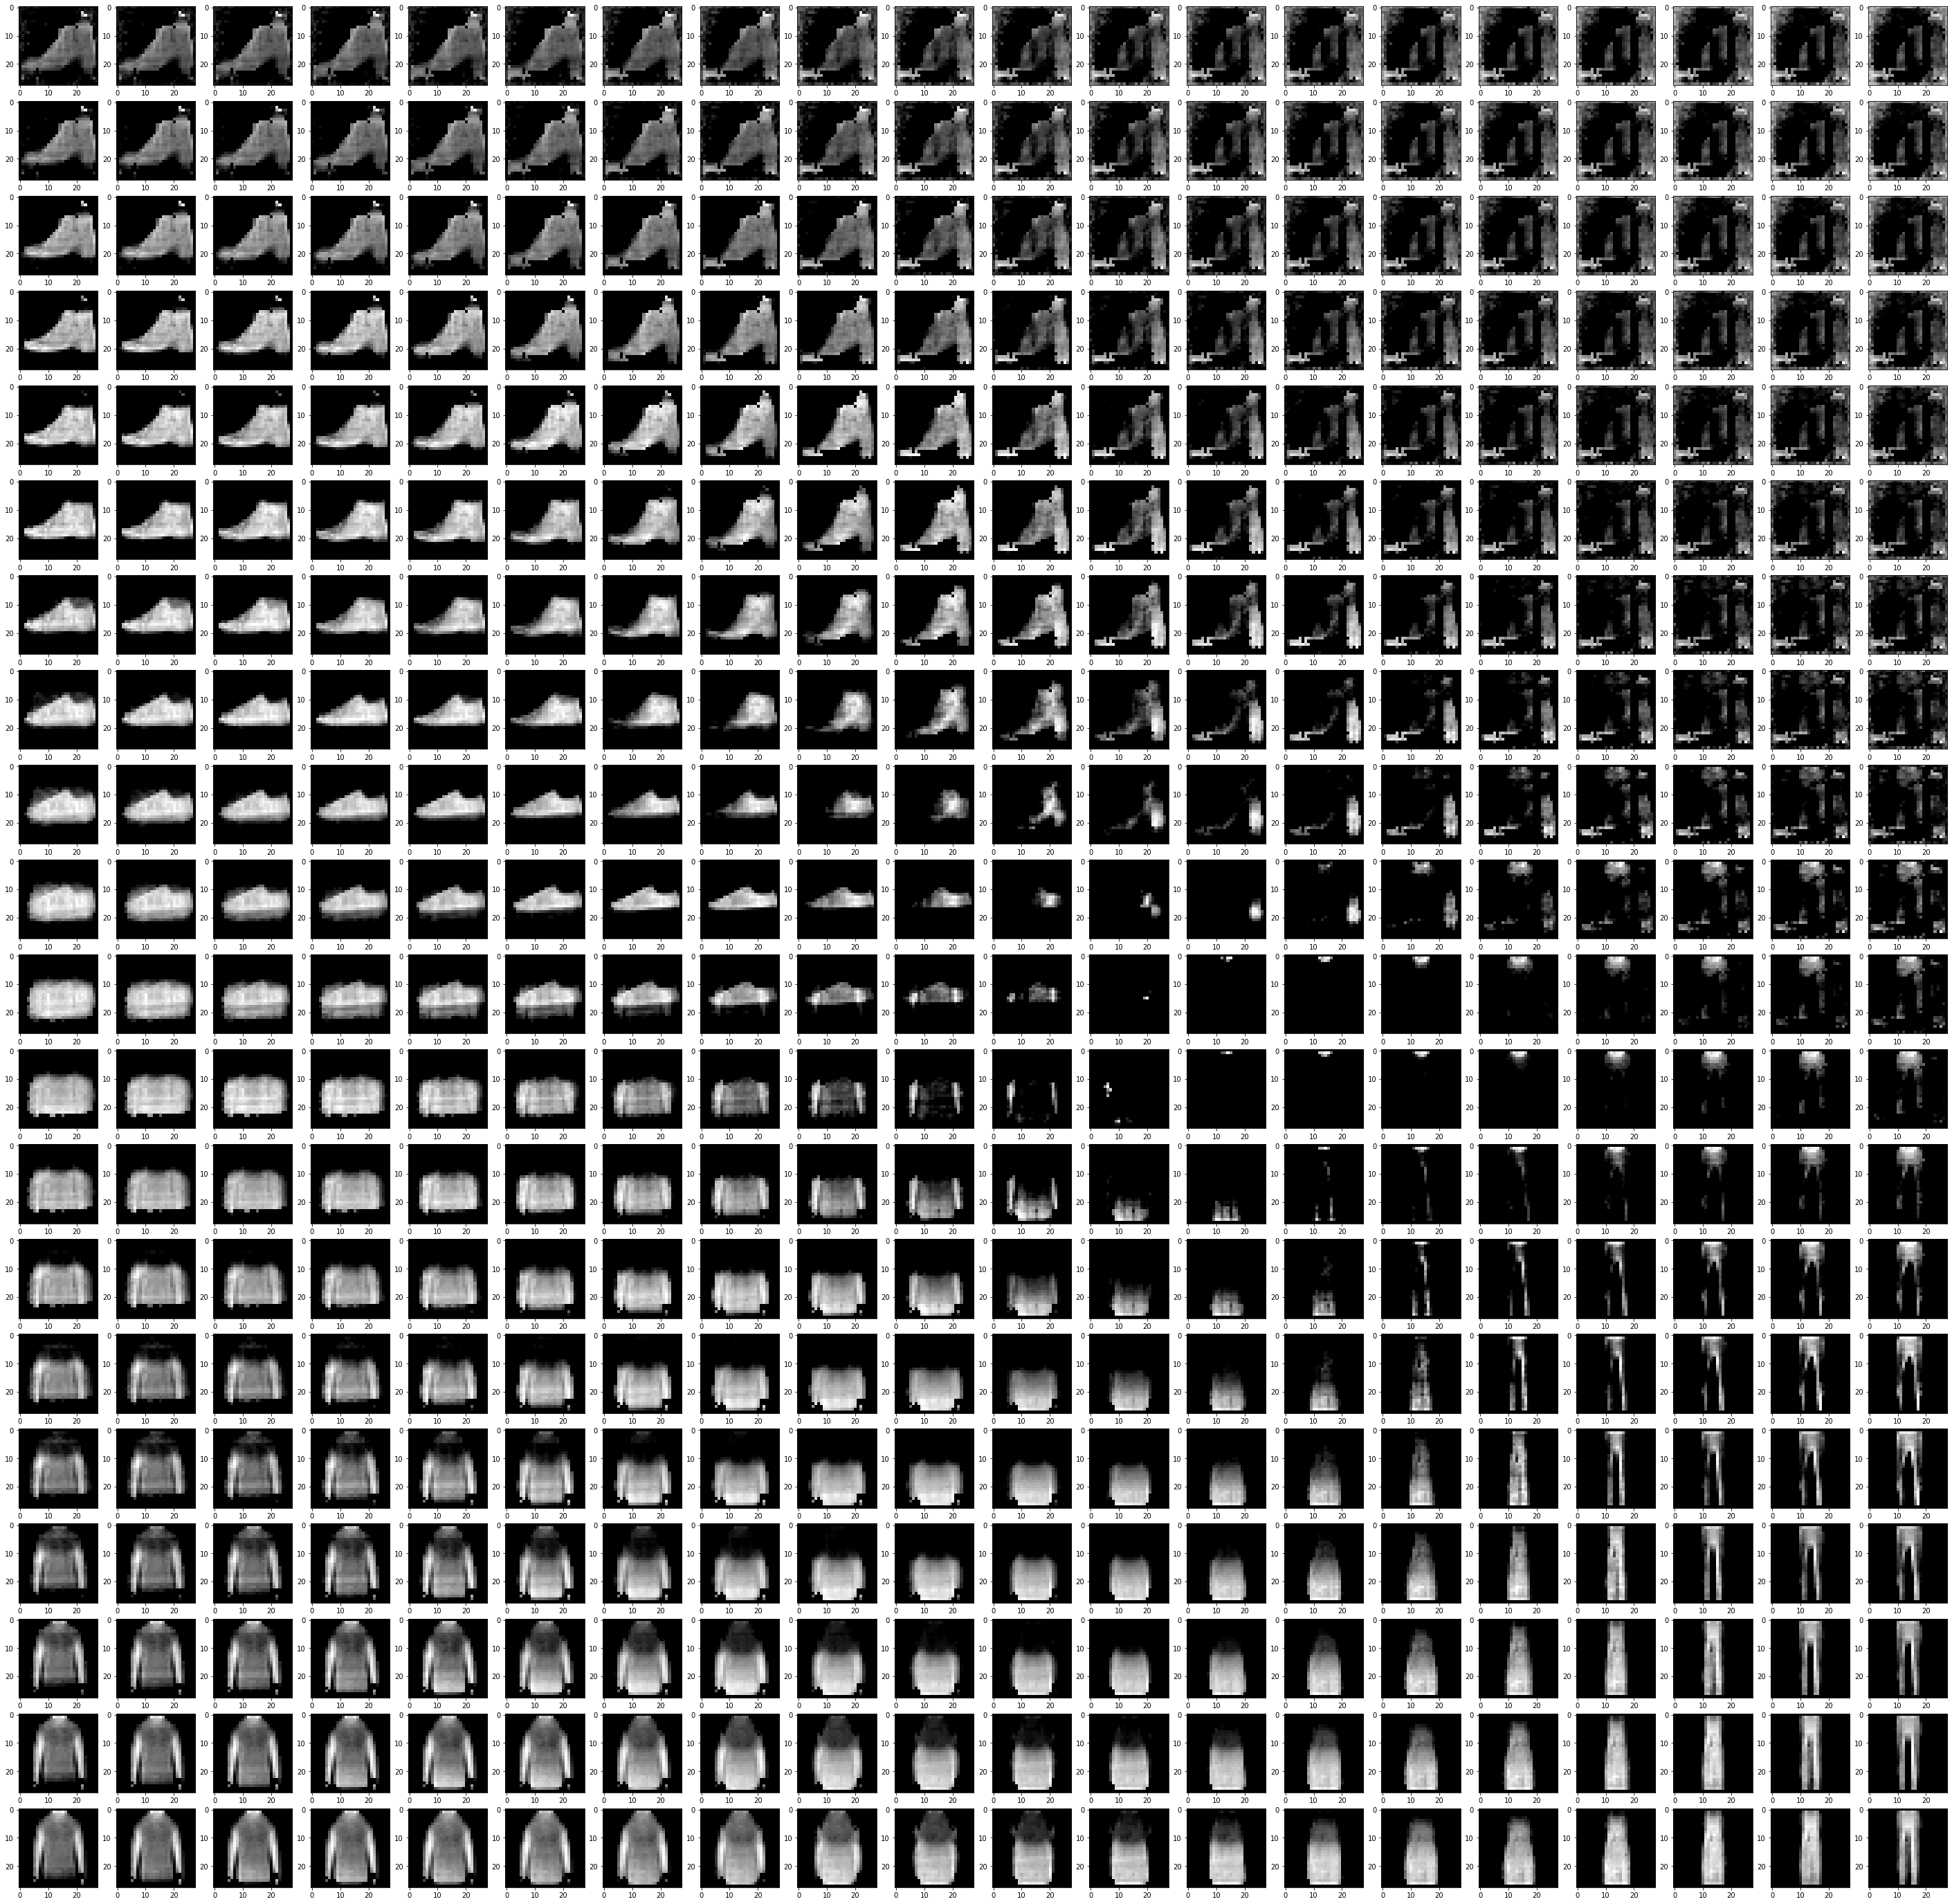

In [16]:
sampled_img.shape
plt.figure(figsize=(50,50))
sampled_img += 0.5
for i in np.arange(400):
    plt.subplot(20,20,i+1)
    plt.imshow(np.reshape(sampled_img[i],(28,28)),cmap='gray')